In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%%html

<a href="https://jy2014.github.io/EpilepsyPrediction/Home.html" target="_self">Back to the Home Page</a>

# Chapter 2. Data Imputation
___
<p></p>
<font size = "3">Survey data sets usually contain missing value due to various reasons, such as missing in error or the respondents refusing to provide answers to certain questions. The dataset of NSCH also faces this missing value problem. Our first task is to impute the missing values in the data set. According to the missingness, type of the question and logic in the survey, we employed different strategies to impute different groups of variables. </font>

<font size = '3'>
- [2.1. Exploring Non-Numerical Data Entries](#2.1.Exploring-Non-Numerical-Data-Entries)
- [2.2. Reading Data and Exploring Indicators in Variables ](#2.2.Reading-Data-and-Exploring-Indicators-in-Variables)
- [2.3. Get Frequency of Categorical Indicators in Different Variables](#2.3.Get-Frequency-of-Categorical-Indicators-in-Different-Variables)
- [2.4. Rank Variables by Missingness](#2.4.Rank-Variables-by-Missingness)
- [2.5. Strategy of Handling Categorical Indicators and Missing Data](#2.5.Strategy-of-Handling-Categorical-Indicators-and-Missing-Data)
- [2.6. Dropping Extreme Missingness and Uncompleted Surveys](#2.6.Dropping-Extreme-Missingness-and-Uncompleted-Surveys)
- [2.7. Simple Imputation of Some Columns with Missing Data Using Mean or Majority](#2.7.Simple-Imputation-of-Some-Columns-with-Missing-Data-Using-Mean-or-Majority)
- [2.8. Imputing Poverty Level](#2.8.Imputing-Poverty-Level)
___

*** please click the button on top of the page to view the code ***

In [4]:
#### USING NSCH 2007 Data and NSCH 2007 Variable Description PDF, explore data missingness
from IPython.display import Image

import numpy as np
import pandas as pd
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize

from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression as Log
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

import itertools as it
import matplotlib as plt
% matplotlib inline

# Be able to print more text
pd.options.display.max_colwidth = 1000  

___
## 2.1.Exploring Non-Numerical Data Entries ##
<p></p>
<p><font size = "3">In the NSCH 2007, possible categorical responses to questions include <b>numerical values</b> denoting "No", "Yes", or refusal to answer, as well as <b>categorical indicators</b> denoting skipped questions or missing data.</p>
<p></p>
<p>Because Python's classification algorithms take only numerical inputs, we first explored the <b>prevalence and meaning of non-numerical indicators in our dataset.</b></p> 

### Description of Categorical Indicators in Survey Responses ###
<p></p>
<p><font size = "3">The [survey methodology](https://www.cdc.gov/nchs/data/series/sr_01/sr01_055.pdf) from the US Center of Disease Control includes descriptions of categorical indicators in the NSCH 2007.</font><p>
<p></p>
<img src = "https://cloud.githubusercontent.com/assets/9686980/21193034/bf41c456-c1f8-11e6-9abe-00870b523ec8.jpg" alt="table with description of categorical indicators"/>

### **Example Question:** 
<p></p>
<font size = "3"><b>To illustrate the meaning of these categorical indicators, we included an example from the NSCH Survey Methodology</b>. Question K2Q31A was preceded by the question "Has a doctor... ever told you that [Child] had emotional, developmental, or behavioral problems?". Families who responded "NO" to this precedent question were not asked about K2Q31A, and represent "Legitimate Skips" in the dataset. "Missing" values denote erroneously skipped entries.</font>

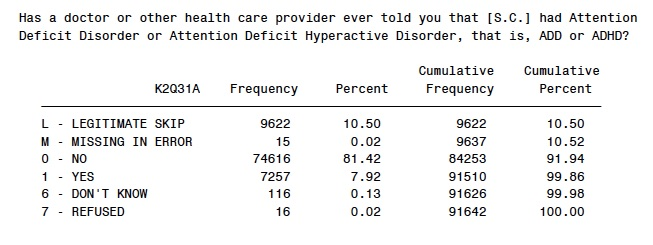

In [3]:
Image('pic/nsch_imputation.jpg')

___
## 2.2.Reading Data and Exploring Indicators in Variables ##


<font size = "3">Our data were downloaded from the [CDC website](https://www.cdc.gov/nchs/slaits/nsch.htm) in <b>SAS4BDAT format</b>. We used the program SAS to read the data and convert it to a CSV file. This CSV file was then read into Python using Pandas. In a separate script, we processed the NSCH 2007 Variable Description PDF to create a CSV containing variable names and their associated questions. </font>

In [4]:
# Load NSCH 2007
nsch_df = pd.read_csv ('NSCH_2007.csv')

# WARNING: sys:1: DtypeWarning: Columns (2,3,4,9,232,233,235) have mixed types. Specify dtype option on import or set low_memory=False.
col_names = nsch_df.columns

# Read CSV containing variable names and descriptions
var_description = pd.read_csv ('variable_description.csv')

print 'Total Shape of NSCH 2007 Dataset', nsch_df.shape
print 'Example Entry in NSCH 2007 Dataset:', '\n', nsch_df.head (n=3)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,9,232,233,235) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Total Shape of NSCH 2007 Dataset (91642, 298)
Example Entry in NSCH 2007 Dataset: 
   IDNUMR  STATE MSA_STAT TOTKIDS4 AGEPOS4  AGEYR_CHILD  FLG_06_MNTH  \
0   90597      3        1        3       3           10            0   
1   13527     26        2        1       1           10            0   
2   70867     43        1        1       1           17            0   

   FLG_18_MNTH  SEX RELATION     ...      K11Q37AR  K11Q43R K11Q50  \
0            0    2        2     ...             M        3      1   
1            0    2        1     ...             M        1      1   
2            0    1        1     ...             M        4      1   

  POVERTY_LEVELR K11Q60  K11Q61  K11Q62 OTH_LANG SUMMER      NSCHWT  
0              6      0       0       0        0      0  460.575625  
1              7      L       L       L        0      1  158.913350  
2              3      0       0       0        0      0  163.073003  

[3 rows x 298 columns]


<font size = "3"><b>Evidently, our raw dataset is large and includes over 90,000 entries with approximately 300 features</b>. In addition, the majority of features appear to be <b>categorical</b>, and include both <b>numeric and character value datatypes</b>. This initial examination of our dataset demonstrates several possible challenges. First, because the Python Sklearn package, which we aimed to use for classification, does not allow for character inputs, we decided to identify methods to handle with these indicators. Second, the size of the dataset suggests that computation time may be slow, especially while cross validating parameters. </font>

___
## 2.3.Get Frequency of Categorical Indicators in Different Variables##

<font size = "3">To substitute numerical values for categorical indicators in different variables, as well as handle missing data, we first counted the number of categorical indicators of each type in different variables. <font>
<p></p>

<p><font size = "3"><b>Here is an output of the counts: </b></font></p>

In [5]:
# Indicator characters denoting: not in universe, legit skip, partial completion, missing in error, added question, deleted question
indicator_char = ['N', 'L', 'P', 'M', 'A', 'D']
                          
# FUNCTION: get_indicator_chars: takes dataframe and counts the number of categorical indicators in each column,
# identifies whether columns are categorical/quantitative.
# INPUTS:
    # df: Dataframe
    # indicator_char: list of indicator characters in dataset (default ['N', 'L', 'P', 'M', 'A', 'D'] )
    # Threshold: int, max number of unique values for variable to be coded as "categorical" (default 20)
# OUTPUTS:
    # List of categorical column indices
    # List of categorical column names
    # df of variables with counts of indicator chars
    
def get_indicator_chars (df, indicator_char = ['N', 'L', 'P', 'M', 'A', 'D'], threshold = 20):
    col_names = df.columns
    
    num_char = np.zeros((len(col_names), len(indicator_char)))
    categorical_col = np.zeros((len(col_names)))

    # Explore missingness: Look for character-coded values
    for i in range(len(col_names)):
        
        # Get counts of unique values in each column
        unique_value_counts = df[col_names[i]].value_counts(sort = True, dropna = False)
        
        # Determine if categorical
        categorical_col[i] = len(unique_value_counts) < threshold
        
        for c in range(len(indicator_char)):
            try:
                # Get number of entries with indicator char (IF EXISTS, ELSE returns error)
                num_char[i,c] = unique_value_counts[indicator_char[c]]
            except:
                # If error returned, set to zero (not found)
                num_char[i,c] = 0
    # Categorical Column Names
    cat_col_names = col_names[np.where(categorical_col)[0]]
    
    # Create Dataframe containing Indicator Chars per Column
    coded_indicators_df = pd.DataFrame(data = num_char, index = col_names, columns = indicator_char, dtype = int)
    
    return categorical_col, cat_col_names, coded_indicators_df

categorical_col, cat_col_names, coded_indicators_df = get_indicator_chars (nsch_df)

print 'Categorical Indicator Counts in each Feature:', '\n', coded_indicators_df

Categorical Indicator Counts in each Feature: 
                    N      L     P      M  A  D
IDNUMR              0      0     0      0  0  0
STATE               0      0     0      0  0  0
MSA_STAT            0  28485     0      0  0  0
TOTKIDS4            0      0     0      1  0  0
AGEPOS4             0      0     0      1  0  0
AGEYR_CHILD         0      0     0      0  0  0
FLG_06_MNTH         0      0     0      0  0  0
FLG_18_MNTH         0      0     0      0  0  0
SEX                 0      0     0      0  0  0
RELATION            0      0     0      1  0  0
PLANGUAGE           0      0     0      0  0  0
K2Q01               0      0     0      0  0  0
K2Q01_D             0   4769     0     19  0  0
K2Q02R          45745      0     0      0  0  0
HGHT_FLG        45745      0     0      0  0  0
K2Q03R              0      0     0      0  0  0
WGHT_FLG            0      0     0      0  0  0
BMICLASS        45745      0     0   1796  0  0
K2Q04R              0      0     0  64830

<font size="3"> From visually examining the frequency of categorical indicators in each feature, it appears that there are some features with very few coded values, and that a large proportion of coded values indicate Legitimate Skips ("L"). Moreover, there are some survey questions with large numbers of Missing ("M") values, which will also be handled. </font>

___
## 2.4.Rank Variables by Missingness ##

<font size = "3">To determine which variables have the largest number of missing values (coded as "M"), we sorted the above dataframe, visualized the extent of missingness, and printed out the descriptions of the questions. The <b>questions with the most missing questions are related to immigration status and parental cohabitation</b>.</font> 

In [7]:
# Examine Missing
sorted_M = coded_indicators_df['M'].sort_values(ascending = False)
# print 'Variables by number of Missing Values:', '\n', sorted_M

### Total Responses Missing, Ranked
<p></p>
<font size = "3">The figure below shows the counts of 'M' responses in features, sorted by count values. </font>

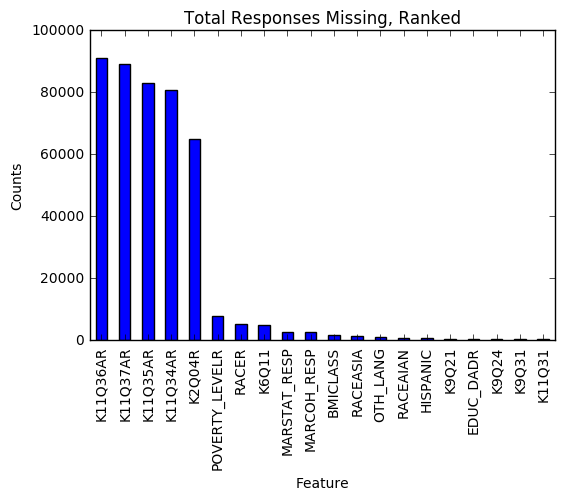

In [8]:
ax_missing = sorted_M[:20].plot(kind = 'bar', title = 'Total Responses Missing, Ranked')
ax_missing.set_xlabel('Feature')
ax_missing.set_ylabel('Counts')

# # Get Descriptions of top 10 missing vars
# print 'Descriptions of top 10 missing vars:', '\n'
# for i in range(10):
#     print var_description.loc[var_description['variable'] == sorted_M.index[i]]['descriptions'], '\n'

___
## 2.5.Strategy of Handling Categorical Indicators and Missing Data##
<p></p>
<font size = "3"><p>Given that our dataset contains many missing values, we had to consider whether the features containing too many missing values would influence the performance of the model in predicting epilepsy diagnosis. Therefore, if we tried to impute the missing values of dataset, we need to consider thoughtfully for both design of survey and nature of questions instead of just simply filling the dataset with mean, zeros or majority vote.<p>
<p></p>
<p>Options for handling missing data include dropping all features or entries with missing values, which would reduce the size of our training set significantly. Alternatively, to preserve the size of the dataset, several imputation methods including mean, zeros, majority vote or even fitting models based on other features without missing values can be used to fill in missing data. In our dataset, most predictors are categorical (including questions with a few response options) and take on a small set of values, while some other predictors are quantitative (ex: height and weight).<p>
<p></p>
<p><b>Our methods are summarized in the below table, and are described in more detail in the next three sections</b>.</p>
<p></p></font>

<font size = "4"><b>Summary Table: Handling of Categorical Indicators</b><font>

<img src="https://cloud.githubusercontent.com/assets/9686980/21193038/c2606426-c1f8-11e6-9354-3cfebe9e1826.jpg" alt="handling the missing data" />

___
## 2.6.Dropping Extreme Missingness and Uncompleted Surveys##
<p></p>
<p><font size = "3">To handle the missing data, we first ranked features by the proportion missing and examined the data for a natural cutoff. There are only 5 features with more than 60% of values missing, most of which are related to family immigration status. Because this missingness affects a large proprtion of entries, and because we did not believe immigration to be a critical predictor of epilepsy status or quality of life, we decided to <b>drop columns with more than 60% missingness</b>. Therefore, the next feature with most missingness was Poverty Level, which describes household income based on an 8-level scale determined by the Department of Health and Human Services. The imputation of Poverty Level is described in Section 2.8. <p>
<p></p>
<p>To handle <b>indicators of incomplete surveys</b>, including P, A, and D, we noticed that only 1 column contained A or D values, indicating that these questions were added or deleted after the survey started. Because these constituted a small portion of the dataset, we decided to remove this column. In addition, there were only 5 rows (respondents) with any P values (indicating a prematurely ended interview), so we decided to drop these respondents due to their small number. </p></font>

In [9]:
### HANDLING THE MISSING DATA

# Drop the columns missing over 50,000 values
# After that, the missing vars are related to demographics (poverty, race, marriage, language)
nsch_drop_df = nsch_df.drop(sorted_M[sorted_M > 50000].index, axis = 1)
len(nsch_drop_df.columns)

# Drop columns with A or D
nsch_drop_ad_df = nsch_drop_df.drop('K2Q30D', axis= 1)

# Drop rows with P (did not complete survey)
# How many rows have P = 1066
rows_with_P = np.where(np.sum(nsch_drop_ad_df.values == 'P', axis = 1))[0]
nsch_drop_adp_df = nsch_drop_ad_df.drop(rows_with_P, axis = 0)

# Check how many p left ( should be 0)
print 'Number of P entries left:', np.sum(nsch_drop_adp_df.values == 'P')
print 'New shape:', nsch_drop_adp_df.shape
final_cols = nsch_drop_adp_df.columns


### Explore which of L are categorical
# L - another category
((coded_indicators_df['L'] > 0).values)*(1-categorical_col)

# Column
col_names[np.where(((coded_indicators_df['L'] > 0).values)*(1-categorical_col))[0]]
          
# Columns with L
cat_col_L = col_names[np.where(categorical_col == 1)[0]] # Categorical columns names

noncat_col_L = col_names[np.where(((coded_indicators_df['L'] > 0).values)*(1-categorical_col))[0]]

# Noncategorical L questions             
noncat_L_questions = [var_description.loc[var_description['variable'] == noncat_col_L[i]].descriptions for i in range(len(noncat_col_L))]
 
# for j in range(len(noncat_col_L)):
#     print noncat_L_questions[j] + '\n'

### N 
N_cols = col_names[np.where((coded_indicators_df['N'] > 0 ))[0]]

# Find noncategorical N columns
noncat_col_N = col_names[np.where(((coded_indicators_df['N'] > 0).values)*(1-categorical_col))[0]]         
noncat_N_questions =[var_description.loc[var_description['variable'] == noncat_col_N[i]].descriptions for i in range(len(noncat_col_N))]

# for j in range(len(noncat_col_N)):
#     print noncat_N_questions[j] + '\n'
# Lots of intersection between L, N, so treat the same! Need to manually go thru and see what to do with each


Number of P entries left: 0
New shape: (90576, 292)


___
## 2.7.Simple Imputation of Some Columns with Missing Data Using Mean or Majority##
<p></p>
<font size = "3">Based on the design of the survey and nature of questions, we either imputed mean or majority or zeros, or created different categories for categorical indicator variables. However, for Poverty Level, we decided to <b>use models based on other predictors for imputation</b>. We chose to do this because Poverty Level, as a measure of household income, is an important demographic characteristic that is associated with health and healthcare access, and thus may be predictive of epilepsy status. After filling in missing data in the other columns using mean and majority imputaiton, we acquired a dataset that we could use to impute Poverty Level, described in Section 2.8.</font>

In [6]:
######################
#### DOING IMPUTATION
######################

# Double check that all ADP dropped
drop_vals = ['A', 'D', 'P']
print 'Number of A, D, P:', [np.sum(nsch_drop_adp_df.values == drop_vals[i]) for i in range(len(drop_vals))]

## Create new matrix: drop ADP, coded LMN 
nsch_drop_adp_code_lmn_df = nsch_drop_adp_df

### Categorical Columns
cat_col_names_final= list(set(final_cols).intersection(cat_col_names))

## Categorical: Replace L,N values with -2
nsch_drop_adp_code_lmn_df[cat_col_names_final] = nsch_drop_adp_code_lmn_df[cat_col_names_final].replace(to_replace = ['L', 'N'], value = -2)

## Categorical: Impute M with majority class
# EXCEPT: for Poverty Level -> remove variable from list
cat_col_impute = cat_col_names_final [:] # Copy list
cat_col_impute.remove ('POVERTY_LEVELR') # Remove PovertyLevel from list of cols to impute
print len (cat_col_impute) # should be 271

# convert M to NaN in imputing columns
nsch_drop_adp_code_lmn_df[cat_col_impute] = nsch_drop_adp_code_lmn_df[cat_col_impute].replace('M', np.nan)

# Run preprocessing Imputer with Most Frequent Imputation
imp_cat = Preprocessing.Imputer (missing_values ='NaN', strategy='most_frequent', axis=0)
# Replace columns with imputed columns
nsch_drop_adp_code_lmn_df[cat_col_impute] = imp_cat.fit_transform(nsch_drop_adp_code_lmn_df[cat_col_impute])

categorical_col_final_det, cat_col_names_final_dt, coded_indicators_df_cat = get_indicator_chars (nsch_drop_adp_code_lmn_df[cat_col_names_final])

print coded_indicators_df_cat
len(coded_indicators_df_cat.index) # should be 272
print 'Remaining M in POVERTY_LEVELR:', coded_indicators_df_cat.loc['POVERTY_LEVELR']['M']


### Quantitative Columns
quant_col_names_final = list(set(final_cols).difference(cat_col_names_final))

## EXCEPT: for K9Q16R [Mother's Age] L -> convert these to M
# Convert L in column K9Q16R to M
nsch_drop_adp_code_lmn_df['K9Q16R'] = nsch_drop_adp_code_lmn_df['K9Q16R'].replace('L', 'M')

## Quantitative: replace L, N values with 0
nsch_drop_adp_code_lmn_df[quant_col_names_final] = nsch_drop_adp_code_lmn_df[quant_col_names_final].replace(to_replace = ['L', 'N'], value = 0)

## Quantitative: Impute M with mean
# convert M to NaN
nsch_drop_adp_code_lmn_df[quant_col_names_final] = nsch_drop_adp_code_lmn_df[quant_col_names_final].replace('M', np.nan)
imp_quant = Preprocessing.Imputer (missing_values ='NaN', strategy ='mean', axis=0)
nsch_drop_adp_code_lmn_df[quant_col_names_final] = imp_cat.fit_transform(nsch_drop_adp_code_lmn_df[quant_col_names_final])


categorical_col_final_det, cat_col_names_final_dt, coded_indicators_df_final = get_indicator_chars (nsch_drop_adp_code_lmn_df)

print 'Coded Indicators All Columns:', coded_indicators_df_final
print 'Num Remaining M All Columns:', np.sum(coded_indicators_df_final['M'])
 

### Write Dataframes to CSV format

print 'Final Shape of Dataset:', nsch_drop_adp_code_lmn_df.shape

# nsch_drop_adp_code_lmn_df.to_csv ('NSCH_2007_droppedADP_codeLMN.csv')

# Might be easier to handle if we code M as NaN

nsch_drop_adp_code_lmn_df_na = nsch_drop_adp_code_lmn_df.replace ('M', np.nan)
# nsch_drop_adp_code_lmn_df_na.to_csv ('NSCH_2007_droppedADP_codeLMN_na.csv')
# print nsch_drop_adp_code_lmn_df_na.shape
# print nsch_drop_adp_code_lmn_df_na ['POVERTY_LEVELR']

colfin = nsch_drop_adp_code_lmn_df.columns
cat_col_names_final_dt
[np.sum(colfin == cat_col_names_final_dt[i]) for i in range(len(cat_col_names_final))]
[np.sum(colfin == quant_col_names_final[i]) for i in range(len(quant_col_names_final))]

set(cat_col_names_final_dt).difference(cat_col_names_final)

# Add 'STATE' to Categorical column names (was encoded as Quantitative)
cat_col_names_final.append ('STATE')

categorical_column_names_ser = pd.Series (cat_col_names_final)
# categorical_column_names_ser.to_csv ('Categorical_Column_Names_wState.csv')
 

___
## 2.8.Imputing Poverty Level##
<p></p>
<p><font size = "3">To assess imputation accuracy for different models, we used the subset of our data with complete Poverty Levels and used k-Fold Cross-Validation to get a cross-validation accuracy for each model. Then we trained the best model on the complete subset, and used it to predict poverty level for the subset with missing data. </p>

The models evaluated were:
- Baseline Model
- Random Forest Imputation
- Weighted Logistic Regression
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis

An alternative approach would have been to perform [multiple imputation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/), which produces multiple imputed datasets, allowing us to get confidence intervals on population estimates. We attempted this approach in R and Python and saw that the computation time exceeded 10 hours for our large dataset, so we decided to use single imputation models as described.</font>

### NOTE: Imputation with different models was done on different computers, because each takes more than 1 hour to complete due to the size of the dataset! ###

In [7]:
# load the data set
DF = pd.read_csv('NSCH_2007_droppedADP_codeLMN_na.csv')
print DF.shape
DF.head()
# remove ID number and epilepsy related columns
DF_for_impute = DF.drop(['Unnamed: 0','IDNUMR', 'K2Q42A', 'K2Q42B', 'K2Q42C'], axis = 1);

## Encode categorical variables

# read in categorical column names
df_categorical_names = pd.read_csv('Categorical_Column_Names_wState.csv', header = None)

print df_categorical_names.shape
df_categorical_names.head()

# the categorical columns in the dataset
categorical_names = df_categorical_names.values[:,1]

# remove epilepsy related names
categorical_names = categorical_names[categorical_names != 'K2Q42A']
categorical_names = categorical_names[categorical_names != 'K2Q42B']
categorical_names = categorical_names[categorical_names != 'K2Q42C']
# remove poverty level as well since it is our response variable
categorical_names = categorical_names[categorical_names != 'POVERTY_LEVELR']

# Apply one hot endcoing
DF_for_impute_dummies = pd.get_dummies(DF_for_impute, columns = categorical_names)

print "Dimension of the dataset: ", DF_for_impute_dummies.shape
DF_for_impute_dummies.head()

## Split training, testing and validation sets
# extract poverty columns
poverty = DF_for_impute['POVERTY_LEVELR'].values
# rows with missing values
miss_index =np.isnan(poverty)

print "Number of missing values:", np.sum(miss_index)
## extract numpy arrays from the data
# response is needed only for the complete set
y_complete = DF_for_impute['POVERTY_LEVELR'].values[miss_index == False]

# predictors
DF_for_impute_dummies = DF_for_impute_dummies.drop(['POVERTY_LEVELR'], axis = 1);
x = DF_for_impute_dummies.values

x_complete = x[miss_index == False]
x_missing = x[miss_index == True]

print "Dimenstion of x in the complete set: ", x_complete.shape
print "Dimenstion of x in the set missing poverty level: ", x_missing.shape

## split the complete set into training, validation and testing sets
# train the models on training set
# use validation set to select parameters
# use the accuracy on the test set to compare the final models

n = x_complete.shape[0]
perm = range(n)
np.random.shuffle(perm)

split_ratio_1 = 0.70 # use 75% as training set
split_ratio_2 = 0.15 # use 15% as validation set
split_num_1 = int(split_ratio_1 * n)
split_num_2 = int((split_ratio_1 + split_ratio_2) * n)

x_train = x_complete[perm[: split_num_1], :]
x_validation = x_complete[perm[split_num_1: split_num_2], :]
x_test = x_complete[perm[split_num_2: ], :]

y_train = y_complete[perm[: split_num_1]]
y_validation = y_complete[perm[split_num_1: split_num_2]]
y_test = y_complete[perm[split_num_2: ]]

print "Dimension of predictors in training set: ", x_train.shape
print "Dimension of predictors in validation set: ", x_validation.shape
print "Dimension of predictors in testing set: ", x_test.shape

<font size = "4"><b><li> Baseline Model (randomly assign classes)</li></b></font>

<DD><font size = "3">The Baseline Model randomly assigns each child to one of 8 poverty levels, and thus had an accuracy of <b>12%</b>.</font>

In [12]:
# randomly assign each observation to classes
y_baseline = np.zeros(len(y_test))
classes = (np.unique(y_complete))

for i in range(len(y_test)):
    # randomly choose from the list
    y_baseline[i] = np.random.choice(classes)
    
# accuracy rate
# print 'Accuracy rate of baseline model is:', np.mean(y_baseline == y_test)

<font size = "4"><b><li> Random Forest Imputation</li></b></font>

<DD><font size = "3">We next evaluated the Random Forest model for imputation of Poverty Level. Random forests are an intuitive algorithm that can be trained to classify categorical variables. We tuned the maximum tree depth and the minimum node size, and used cross-validation to choose the best model. We identified the best model and ran it on the test set (missing values) to make predictions. <b>Random Forest ultimately had the highest cross-validated accuracy rate at 65%</b>.</font>


In [15]:
import sys

# parameters to tune random forest
max_depth_list = range(1, 21)
min_leaf_list = range(1, 6)

# prepare to display the progress
total_iter = len(max_depth_list) * len(min_leaf_list)
bar_length = 50
i = 0

# tune the tree
best_score = 0
best_depth = 0
best_leaf_num = 0

# evaluate using cross validation
for depth in max_depth_list:
    for leaf in min_leaf_list:
        # fit the model
        rf = RandomForest(n_estimators=100, max_depth= depth, min_samples_leaf= leaf)
        rf.fit(x_train, y_train)
        # accuracy
        score = rf.score(x_validation, y_validation)

        # update the best score and parameters
        if score > best_score:
            best_score = score
            best_depth = depth
            best_leaf_num = leaf
            rf_best = rf
        
        # display the progress
        percent = float(i) / total_iter
        hashes = '#' * int(round(percent * bar_length))
        spaces = ' ' * (bar_length - len(hashes))
        sys.stdout.write("\rProgress: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
        sys.stdout.flush()
        i = i + 1
        
print "\nThe optimal depth is {}; the optimal minimum number of samples in each node is {}.".format(
    best_depth, best_leaf_num)  

print "The best testing accuracy is ", best_score

In [16]:
# # the best model (DETERMINED BY CROSS VALIDATION: TAKES A LONG TIME TO RUN SO WE JUST INPUT THE PARAMETERS HERE!!!)
best_depth = 18
best_leaf_num = 2
rf_best = RandomForest(n_estimators=100, max_depth = best_depth, min_samples_leaf = best_leaf_num)
rf_best.fit(x_train, y_train)

score = rf_best.score(x_test, y_test)
# print "The testing accuracy of the final random forest model is ", score

<font size = "4"><b><li> Weighted logistic regression</li></b></font>

<DD><font size = "3">We also tried weighted logistic regression (with an L2 penalty) and tuned the regularization parameter. We achieved the highest accuracy rate with $C = 10^{-3}$, with an accuracy of **64.8%**, similar to the accuracy of the Random Forest. Because the Random Forest gave slightly higher accuracy, and because of its more intuitive interpretation, we decided to use the Random Forest to generate the final imputed data set.</font>

In [ ]:
max_pow_of_10 = 7
min_pow_of_10 = -7
num_params = max_pow_of_10 - min_pow_of_10 + 1

cv_r_squared = []

# Iterate over various parameter values
for power_of_10 in range(min_pow_of_10, max_pow_of_10+1):
        #standardize x_train and y_train
    from time import gmtime, strftime
    print strftime("%Y-%m-%d %H:%M:%S", gmtime())
    
    std = Standardize(with_mean=False)
    x_train_std = std.fit_transform(df_x)
    x_test_std = test_x / std.scale_ 
    #print x_train_std
    cv_r_squared.append(k_fold_r_squared(x_train_std, df_y_training, 5, 10**power_of_10))

In [ ]:
# Try logistic regression, with multi_class = 'ovr', first, with regularization parameters(-7 to 7)
def k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold
    

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train[:n * (fold - 1), :]
        x_second_half = x_train[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train[:n * (fold - 1)]
        y_second_half = y_train[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train[1 + n * (fold - 1):n * fold]

        # Fit ridge regression model with parameter value on CV train set, and evaluate CV test performance
        reg = Log(penalty = 'l2', C = param_val)
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

In [8]:
print 'C = 10^-3 returns the best accuracy of weighted logistic regression: 0.648'

<font size = "4"><b><li> Linear Discriminant Analysis</li></b></font>

<DD><font size = "3">Using Linear Discriminant Analysis (LDA), our accuracy was around <b>60%</b>, which is lower than that of weighted logistic regression and Random Forest model.</font>

In [ ]:
def k_fold_r_squared_LDA(x_train, y_train, num_folds):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold
    

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train[:n * (fold - 1), :]
        x_second_half = x_train[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train[:n * (fold - 1)]
        y_second_half = y_train[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train[1 + n * (fold - 1):n * fold]

        # Fit ridge regression model with parameter value on CV train set, and evaluate CV test performance
        reg = LDA()
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

In [ ]:
df_x_array = np.array(df_x)
cv_r_squared_lda = k_fold_r_squared_LDA(df_x_array, df_y_training, 5)
print 'The testing accuracy of the final LDA model is:', cv_r_squared_lda

<font size = "4"><b><li> Quadratic Discriminant Analysis (QDA)</li></b></font>

<DD><font size = "3">The accuracy using Quadratic Discriminant Analysis (QDA) was only <b>20%</b>.</font>

In [ ]:
def k_fold_r_squared_QDA(x_train, y_train, num_folds):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold
    

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train[:n * (fold - 1), :]
        x_second_half = x_train[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train[:n * (fold - 1)]
        y_second_half = y_train[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train[1 + n * (fold - 1):n * fold]

        # Fit ridge regression model with parameter value on CV train set, and evaluate CV test performance
        reg = QDA()
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

In [3]:
# Try QDA
cv_r_squared_qda = k_fold_r_squared_QDA(df_x_array, df_y_training, 5)
print 'The testing accuracy of the final QDA model is:', cv_r_squared_qda

### **Given the performance of the above models, we decided to use Random Forest to impute missing values in Poverty Level and generated our final imputed dataset, which was used in the analysis on the prediction of epilepsy diagnosis and quality of life!**

___

In [9]:
%%html
<a href="https://jy2014.github.io/EpilepsyPrediction/data_source.html" target="_self">Chapter 1. Data Source</a>

In [10]:
%%html
<a href="https://jy2014.github.io/EpilepsyPrediction/Diagnosis.html" target="_self">Chapter 3. Predicting Epilepsy Status</a>

In [11]:
%%html
<a href="https://jy2014.github.io/EpilepsyPrediction/Home.html" target="_self">Back to the Home Page</a>

In [4]:
# Random forest
rf_best.fit(x_complete, y_complete)
y_pred =rf_best.predict(x_missing)

DF['POVERTY_LEVELR'].iloc[miss_index] = y_pred

# DF.to_csv("imputed_PovertyLevel_RF.csv", sep = ',')